In [3]:
using Flux
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using MLDatasets
using Plots

## Get and prepare the data

We load the MNIST train and test data using MLDatasets:

In [4]:
# load full train set
train_x, train_y = MLDatasets.MNIST.traindata(Float32)

# load full test set
test_x, test_y = MLDatasets.MNIST.testdata(Float32)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

We check the shape of the MNIST data:

In [5]:
println("Size of train set: $(size(train_x))")
println("Size of test set: $(size(test_x))")

Size of train set: (28, 28, 60000)
Size of test set: (28, 28, 10000)


As we can see, the train dataset has 60000 examples and the test dataset has 10000. Each element of both datasets is a 28x28 matrix. Flux expects the data to be in a different shape (see image below). 



We need to transform the MNIST data so we can feed it into our Flux model. Thus, we flatten the input data, that is, we convert each 28x28 matrix into a 784-dimensional vector:

In [14]:
# Flatten each image into a vector
train_x = Flux.flatten(train_x)
test_x = Flux.flatten(test_x)

784×10000 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

Now, we need to one-hot encode (see image above - Chris Albon) the labels so that our model can understand them:

In [7]:
# One-hot encode the labels
train_y, test_y = onehotbatch(train_y, 0:9), onehotbatch(test_y, 0:9)

(Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

Whenever we are working with a very large dataset, it is more convenient to work with mini batches of the data. We use Flux's [DataLoader](https://fluxml.ai/Flux.jl/stable/data/dataloader/) type so we can iterate over the mini batches of the data: 

In [8]:
# Create DataLoaders (mini-batch iterators)
train_data_loader = DataLoader((train_x, train_y), batchsize=256, shuffle=true)
test_data_loader = DataLoader((test_x, test_y), batchsize=256)

DataLoader{Tuple{Array{Float32,2},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}}}((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]), 256, 10000, true, 10000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000], false)

## Model

As we mentioned above, our model has one input layer, one hidden layer (with 32 perceptrons), and an output layer (with n_classes perceptrons). 

In [9]:
# Construct model
img_size = (28,28,1)
n_classes = 10

model = Chain( Dense(prod(img_size), 32, relu),
                  Dense(32, n_classes))

ps = Flux.params(model) # model's trainable parameters

Params([Float32[-0.0017218534 0.05448177 … 0.057853024 -0.03525453; -0.06551546 -0.07365144 … 0.05125279 -0.018042415; … ; -0.049772117 -0.012488579 … 0.0053936155 -0.050251473; 0.02933832 0.011481742 … 0.024355408 0.0021731392], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.012481836 -0.0713582 … 0.1783298 0.3768975; 0.14204675 -0.3283766 … 0.28812033 -0.23370884; … ; 0.04115477 0.19755809 … -0.17236012 0.17841288; -0.37440264 0.23192486 … 0.010134373 -0.06286894], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

We create a loss function and an accuracy function. It is very important to monitor loss during training time so we can decide when it's best to stop the training. 

In [10]:
function loss(data_loader, model)
    total_loss = 0.0f0
    #change num to something more meaningful
    num_elements = 0
    for (x, y) in data_loader
        ŷ = model(x)
        total_loss += logitcrossentropy(ŷ, y, agg=sum)
        num_elements +=  size(x)[end]
    end
    return total_loss / num_elements
end


function accuracy(data_loader, model)
    accuracy = 0
    num_elements = 0
    for (x, y) in data_loader
        ŷ = model(x)
        accuracy += sum(onecold(ŷ) .== onecold(y))
        num_elements += size(x)[end]
    end   
    
    return accuracy / num_elements
end

# Comment on why we need both: loss and accuracy

accuracy (generic function with 1 method)

To train our model, we use the gradient descent algorithm. It does the following: 

For this example, we use the ADAM optimiser and set a value η for the learning rate:

In [11]:
 ## Optimizer
η = 3e-4 

opt = ADAM(η)

ADAM(0.0003, (0.9, 0.999), IdDict{Any,Any}())

Finally, we can train our model. We train a neural network in stages (or epochs). In each epoch, we perform one step of the gradient descent algorithm and output the loss and accuracy.

In [12]:
epochs = 40

train_loss_results = []
test_loss_results = []
train_accuracy_results = []
test_accuracy_results = []

for epoch in 1:epochs
    for (x, y) in train_data_loader
        gs = gradient(() -> logitcrossentropy(model(x), y), ps) # compute gradient
        Flux.Optimise.update!(opt, ps, gs) # update parameters
     end
        
    # Compute accuracy and loss for all of the train and test data
    train_loss = loss(train_data_loader, model)
    train_acc = accuracy(train_data_loader, model)
    test_loss = loss(test_data_loader, model)
    test_acc = accuracy(test_data_loader, model)
    println("Epoch=$epoch")
    println("  train_loss = $train_loss, train_accuracy = $train_acc")
    println("  test_loss = $test_loss, test_accuracy = $test_acc")
    push!(train_loss_results, train_loss)
    push!(test_loss_results, test_loss)
    push!(train_accuracy_results, train_acc)
    push!(test_accuracy_results, test_acc)
end

Epoch=1
  train_loss = 0.5755098, train_accuracy = 0.8666
  test_loss = 0.5563042, test_accuracy = 0.8717
Epoch=2
  train_loss = 0.38811642, train_accuracy = 0.8984
  test_loss = 0.37503633, test_accuracy = 0.9018
Epoch=3
  train_loss = 0.32634193, train_accuracy = 0.9111666666666667
  test_loss = 0.31587765, test_accuracy = 0.9145
Epoch=4
  train_loss = 0.29346618, train_accuracy = 0.9189833333333334
  test_loss = 0.2865617, test_accuracy = 0.9224
Epoch=5
  train_loss = 0.27072933, train_accuracy = 0.9254833333333333
  test_loss = 0.26759276, test_accuracy = 0.9254
Epoch=6
  train_loss = 0.2533457, train_accuracy = 0.9304333333333333
  test_loss = 0.25219682, test_accuracy = 0.931
Epoch=7
  train_loss = 0.23954394, train_accuracy = 0.9332666666666667
  test_loss = 0.2388809, test_accuracy = 0.9338
Epoch=8
  train_loss = 0.2272161, train_accuracy = 0.9364666666666667
  test_loss = 0.22827408, test_accuracy = 0.9353
Epoch=9
  train_loss = 0.21546029, train_accuracy = 0.9405833333333333


Plot train and test loss to check overfitting

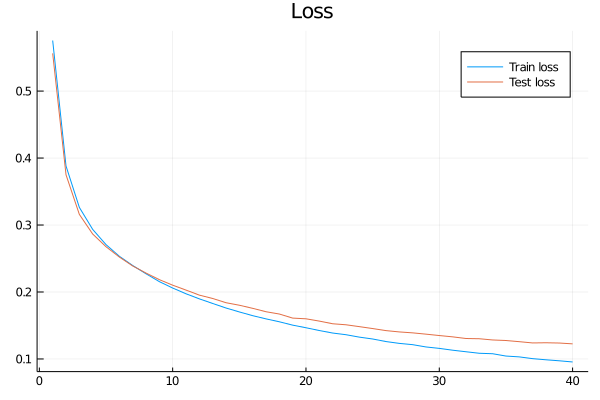

In [13]:
plot(1:length(train_loss_results), train_loss_results, title="Loss", label="Train loss")
plot!(1:length(test_loss_results), test_loss_results, label="Test loss")